# Analysis of PELT signal error due to skip last window update

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-08-02 21:50:32,729 INFO    : root         : Using LISA logging configuration:
2017-08-02 21:50:32,732 INFO    : root         :   /home/joelaf/repo/lisa-aosp/external/lisa/logging.conf


In [2]:
# Generate plots inline
%matplotlib inline
import json
import os
from trace import Trace
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

path_to_dat = "/home/joelaf/repo/lisa-aosp/external/lisa/ipynb/scratchpad/pelt-error/trace-fixed-pc.dat"

## Parse Trace and Profiling Data

In [3]:
trace = Trace(None, path_to_dat, events=[ 'sched_switch', 'pelt_update' ])

## Trace visualization

In [4]:
trappy.plotter.plot_trace(trace.ftrace)

## Latency DataFrames

In [5]:
df = trace.data_frame.trace_event('pelt_update')
rq_df = df[df.cfs_rq == 1]
rq_df.columns

Index([u'__comm', u'__cpu', u'__line', u'__pid', u'__tgid', u'acc_load_avg',
       u'acc_util_avg', u'cfs_rq', u'delta_us', u'load_avg', u'load_err',
       u'load_sum', u'ret', u'sum_err', u'util_avg', u'util_err'],
      dtype='object')

In [6]:
# Plot the accurate and the actual signals for the RQ
print 'UTIL ERROR'
trappy.ILinePlot(trace.ftrace,
                signals = [
                    'pelt_update:util_avg',
                    'pelt_update:acc_util_avg',
                ]).view()

print 'LOAD ERROR'
trappy.ILinePlot(trace.ftrace,
                signals = [
                    'pelt_update:load_avg',
                    'pelt_update:acc_load_avg',
                ]).view()

UTIL ERROR


""
""


LOAD ERROR


""
""


Data showing highest load / util errors (> count of 2) on the RQ (cpu 1)
-------------------------------
Note that, as expected, the error exists only for cases where delta is < 1ms (now - last_update_time)

In [7]:
err_df = rq_df[(rq_df.util_err > 10) | (rq_df.load_err > 10)][rq_df['__comm'] == 'thread0']
err_df = err_df[['__comm',  'acc_load_avg', 'util_avg', 'acc_util_avg', \
                 'util_err', 'delta_us', 'load_sum', 'sum_err', 'load_avg', 'load_err']]

err_df = err_df.sort(columns=['delta_us'], ascending=False)
print 'number of errors: ' + str(len(err_df))
err_df.head(20)


number of errors: 0


/home/joelaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/joelaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,__comm,acc_load_avg,util_avg,acc_util_avg,util_err,delta_us,load_sum,sum_err,load_avg,load_err
Time,,,,,,,,,,


/home/joelaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


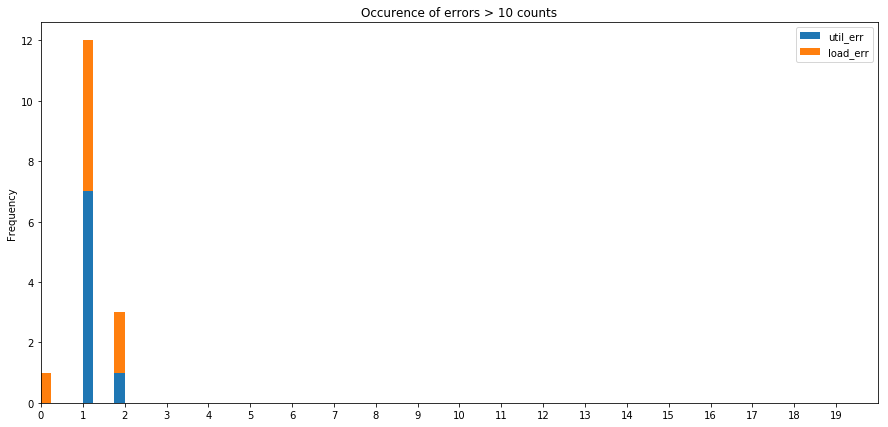

In [8]:
df = rq_df[(rq_df.util_err > 0) | (rq_df.load_err > 0)][rq_df['__comm'] == 'thread0']
df = df[(df.util_err > 0) | (df.load_err > 0)]
df = df[['util_err', 'load_err']].plot(kind='hist', figsize=(15,7), bins=8, xlim=(0, 20), xticks=range(0,20), stacked=True, title = 'Occurence of errors > 10 counts', )